<a href="https://colab.research.google.com/github/ojhaajy/MACHINE_LEARNING/blob/main/medical_Ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)
%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

In [ ]:
# now we'll find all the images matching with cardiomegaly
finding = "Cardiomegaly"
finding = finding.capitalize()

In [ ]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [ ]:
from PIL import Image
image=Image.open('/content/medical-ai/images/Cadiomegaly/train/positive/00029502_006.jpg')
print(image.format)
print(image.size)
image.show()

FileNotFoundError: ignored

In [ ]:
# setting the positive for checking those label having positive outcome that's the dataset hjaving the cardiomegaly images
# negative for those not finding the label as cardiomegaly
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)
print(n)

146


In [ ]:
print(df['label'].to_string(index=False))

 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis
 Atelectasis

In [ ]:
# setting the ratio 80 and 20
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [ ]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [ ]:
#making the root directory
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [ ]:
# NOW WE ARE MOVING THE TRAINING POSITIVE EXAMPLES through iteration
for idx, image in positives[:TRAIN_N].iterrows():
  # source is where the images are actually present on the whole in the dataset
  source =rootdir+image["filename"]
# NOW WE'LL MOVE IT TO POSITIVE LIST UNDER TRAIN section
# the "+" sign means under
  dst=rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source,dst)

# NOW WE'LL DO THE SAME THING FOR THE TESTING'POSITIVE DATASET
for idx, image in positives[TRAIN_N:].iterrows():
  source =rootdir+image["filename"]
  dst=rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source,dst)


# NOW DO IT FOR TRAIN AND TEST NEGATIVE AS WELL
for idx, image in negatives[:TRAIN_N].iterrows():
  source =rootdir+image["filename"]
  dst=rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source,dst)

for idx, image in negatives[TRAIN_N:].iterrows():
  source =rootdir+image["filename"]
  dst=rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source,dst)


print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [ ]:
#  declare two array
positive_imgs,negative_imgs=[],[]
IMAGE_HEIGHT,IMAGE_WIDTH=256,256

for idx,row in positives[:6].iterrows():
# load the image in image_path
  image_path=rootdir+row["filename"]
  image=Image.open(image_path).resize((IMAGE_HEIGHT,IMAGE_WIDTH))
  positive_imgs.append(load_image_into_numpy_array(image))


for idx,row in negatives[:6].iterrows():
# load the image in image_path
  image_path=rootdir+row["filename"]
  image=Image.open(image_path).resize((IMAGE_HEIGHT,IMAGE_WIDTH))
  negative_imgs.append(load_image_into_numpy_array(image))

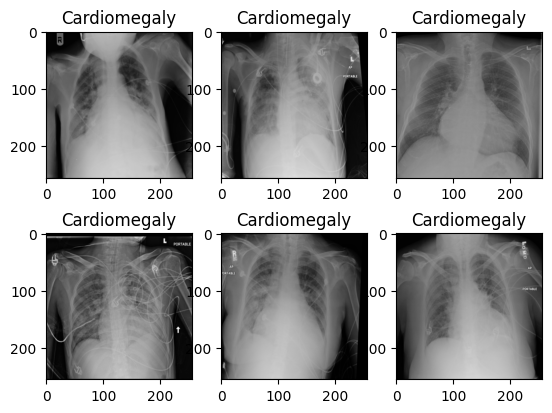

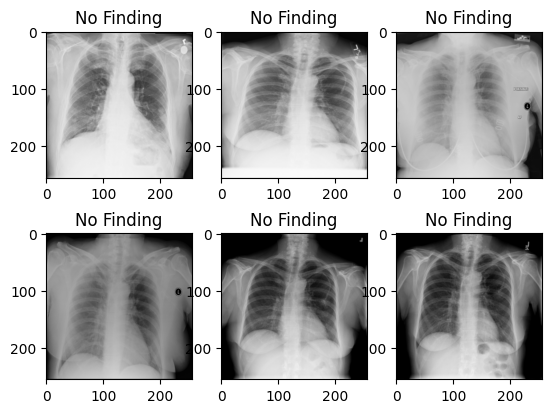

In [ ]:
# printing positive and negative images
for idx, img in enumerate(positive_imgs[:6]):
  # subplot it in 2 rows and 2 column with incrementing idx
  plt.subplot(2,3,idx+1)
  plt.title(finding)
  # the imshow will have in providing 2d image
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2,3,idx+1)
  plt.title("No Finding")
  plt.imshow(negative_imgs[idx])
plt.show()

In [ ]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x) # Add a final sigmoid layer for classification

model = Model(pre_trained_model.input, x) # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

87910968/87910968 [==============================] - 0s 0us/step
Done compiling the model!


In [ ]:
# Define our example directories and files
base_dir='/content/medical-ai/images'
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')



train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

NameError: ignored

In [ ]:
# augmentation is applied here
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
)
# data augmentation shouldn't be applied to the test dataset
val_datagen=ImageDataGenerator(rescale=1/255)

In [ ]:
# train and test generator
train_generator = train_datagen.flow_from_directory('/content/medical-ai/images/Cardiomegaly/train', # This is the source directory for training images
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory('/content/medical-ai/images/Cardiomegaly/test',
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')
# find the number of steps we will use because we have batch size of 1
train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2
print("Done funneling data!")

Found 232 images belonging to 2 classes.
Found 894 images belonging to 2 classes.
Done funneling data!


In [ ]:
#  now we will train the model using the extracted features .training will be done on the 80% part and accuracy will be verified on the remainig 20% part


# By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.

# verbose=0 will show you nothing (silent)

# verbose=1 will show you an animated progress bar like this:

# progres_bar

# verbose=2 will just mention the number of epoch like this:


history=model.fit(
    # point it to train dataset
    train_generator,
    # specify the number of epoch for train
    steps_per_epoch=train_steps,
    epochs=20,
    # now point it to validation
    validation_data= test_generator,
      # specify the number of epoch for test
    validation_steps=test_steps,
    verbose=1
)

Epoch 1/20
232/232 [==============================] - 27s 61ms/step - loss: 11.5378 - acc: 0.5905 - val_loss: 3.7931 - val_acc: 0.6000
Epoch 2/20
232/232 [==============================] - 13s 55ms/step - loss: 3.0128 - acc: 0.6336 - val_loss: 0.6296 - val_acc: 0.8833
Epoch 3/20
232/232 [==============================] - 13s 56ms/step - loss: 1.6798 - acc: 0.6595 - val_loss: 2.9401 - val_acc: 0.1333
Epoch 4/20
232/232 [==============================] - 14s 59ms/step - loss: 0.4560 - acc: 0.7974 - val_loss: 0.3944 - val_acc: 0.8500
Epoch 5/20
232/232 [==============================] - 14s 61ms/step - loss: 0.4822 - acc: 0.7629 - val_loss: 1.4119 - val_acc: 0.5333
Epoch 6/20
232/232 [==============================] - 13s 55ms/step - loss: 0.4204 - acc: 0.8103 - val_loss: 1.1197 - val_acc: 0.6000
Epoch 7/20
232/232 [==============================] - 13s 55ms/step - loss: 0.4507 - acc: 0.8233 - val_loss: 0.7870 - val_acc: 0.6500
Epoch 8/20
232/232 [==============================] - 14s 58m

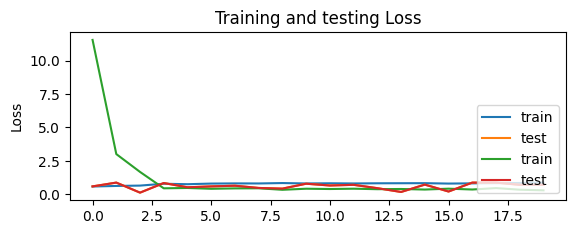

In [ ]:
# creating list for all the accuracy on training and testing set
acc=history.history['acc']
val_acc=history.history['val_acc']

# creating set of all the loss epoch
loss=history.history['loss']
val_loss=history.history['val_loss']


# Get number of epochs
epochs = range(len(acc))

# plotting the acc and val_acc in terms of each epochs
plt.subplot(2,1,1)
plt.plot(epochs,acc,label="train")
plt.plot(epochs,val_acc,label="test")
plt.ylabel("Accuracy")
plt.title('Training and testing accuracy')
plt.legend(loc="lower right")

# plotting the loss and val_loss in terms of each epochs
plt.subplot(2,1,1)
plt.plot(epochs,loss,label="train")
plt.plot(epochs,val_acc,label="test")
plt.ylabel("Loss")
plt.title("Training and testing Loss")
plt.legend(loc="lower right")



In [ ]:
# two parts:
# PART ONE_________
# we'll see how model learned to predict the images categorical way that is we'll assign positive term to those which are cardiomegaly and negatives to other
# ->conver the the imagges dataset into and array between 0 to 255 and if value is greater than 0.5 than its positive other vise negative
# ->then we'll randomly pickup the value of array and see how model is trained to picdict it correctly as cardiomegaly or not

# helper method to open the images and then resize it to what our model requires
# def predict_image(filename):
#   image=images.open(filename).resize((IMAGE_HEIGHT,IMAGE_WIDTH))
#   # load the image to the array using numpy
#   image_np=load_image_numpy_array(image)
#   # set value to each in array from 0 to 255
#   exp=np.true_divide(image_np,255.0)
#   # set the dimension of exp
#   expanded=np.expand_dims(exp,axis=0)
#   # how we'll interact with our model to actually return value between o and 1(1 =cardiomegaly and 0 for not cardiomegaly)
#   return model.predict(expanded)[0][0]

# # let us show each values filepath
# def show_df_row(row):
#   image_path=row('filepath')
#   image=images.open(filename).resize((IMAGE_HEIGHT,IMAGE_WIDTH))
#   # load the image to the array using numpy
#   image_np=load_image_numpy_array(image)
#   # set value to each in array from 0 to 255
#   exp=np.true_divide(image_np,255.0)
#   # set the dimensionexp
#   expanded=np.expand_dims(exp,axis=0)
#   pred =predict(expanded)[0][0]
#   # Cut off point is a certain threshold value which can be used to determine whether an observation belongs to a particular class.
#   guess="neg"
#   if pred > 0.5: guess="pos"
#   title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
#   plt.title(title)
#   plt.imshow(img)
#   plt.show()
#   return

def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return


In [ ]:
# creating a result array and adding all the negative and positive images separately in accordance with along with there confidence
# A Confidence Score is a number between 0 and 1 that represents the likelihood that the output of a Machine Learning model is correct and will satisfy a user's request.

# results=[]
# for image in os.listdir(test_pos_dir):
#    filename = test_neg_dir+"/"+image
#   confidence=predict_image(filename)
#   guess='pos' if confidence>0.5 else 'neg'
#   results.append([filename,image,"pos",confidence])

# for image in os.listdir(test_neg_dir):
#   filename = test_neg_dir+"/"+image
#   confidence=predict_image(filename)
#   guess='pos' if confidence>0.5 else 'neg'
#   results.append([filename,image,"neg",confidence])

# # sort the array on the bases of the last column that is confidence in order of what it thought as cardiomegaly and then not cardiomegaly
# sorted_results=sorted(results,key=lambda x:x[4],reverse=True)
# df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

# results = []
# for image in os.listdir(test_neg_dir):
#   filename = test_neg_dir+"/"+'image
#   confidence = predict_image(filename)
#   guess = 'pos' if confidence > 0.5 else 'neg'
#   results.append([filename, image, "neg", guess, confidence])

# for image in os.listdir(test_pos_dir):
#   filename = test_pos_dir+"/"+'/content/medical-ai/images/Cardiomegaly/test'
#   confidence = predict_image(filename)
#   guess = 'pos' if confidence > 0.5 else 'neg'
#   results.append([filename, image, "pos", guess, confidence])

# sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
# df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

# print("Done inference!")


results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 22ms/step
Done inference!


In [ ]:
df.head(5)

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Cardiomegaly/test/p...,00013615_052.jpg,pos,pos,1.000000
1,/content/medical-ai/images/Cardiomegaly/test/n...,00000459_005.jpg,neg,pos,0.999999
2,/content/medical-ai/images/Cardiomegaly/test/n...,00000459_006.jpg,neg,pos,0.999999
3,/content/medical-ai/images/Cardiomegaly/test/n...,00000459_019.jpg,neg,pos,0.999999
4,/content/medical-ai/images/Cardiomegaly/test/n...,00000459_050.jpg,neg,pos,0.999999


1/1 [==============================] - 0s 35ms/step


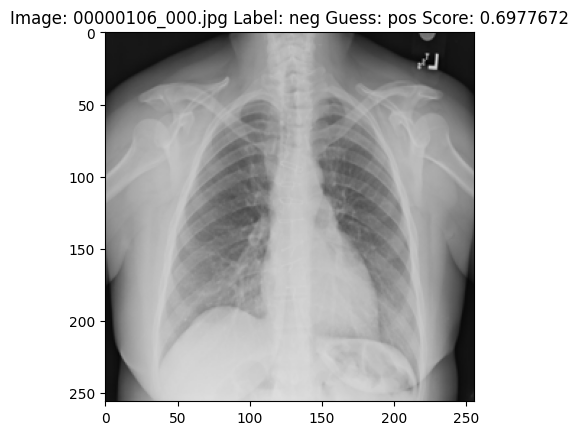

In [ ]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [ ]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,1.000000
5,00004893_085.jpg,pos,pos,0.999997
10,00000459_001.jpg,neg,pos,0.999992
15,00000459_014.jpg,neg,pos,0.999973
20,00000459_002.jpg,neg,pos,0.999952
...,...,...,...,...
870,00000190_005.jpg,neg,neg,0.000762
875,00000296_003.jpg,neg,neg,0.000683
880,00000469_001.jpg,neg,neg,0.000492
885,00000090_000.jpg,neg,neg,0.000406


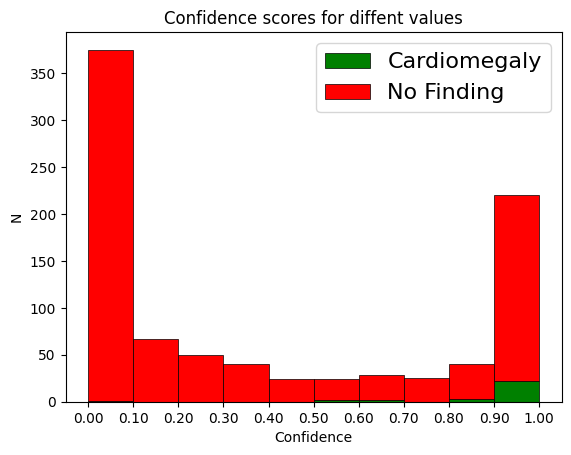

In [ ]:
# now in order to visualize the distribution of our data we will draw the histogram of confidence and label maching pos and neg
# we will also format the numeric value associated with the tick as string
from matplotlib.ticker import FormatStrFormatter
pos=df.loc[df['label']=='pos']["confidence"]
neg=df.loc[df['label']=='neg']["confidence"]
fig, ax=plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'No Finding'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for diffent values')
plt.legend(loc="upper right",fontsize=16)
plt.show()

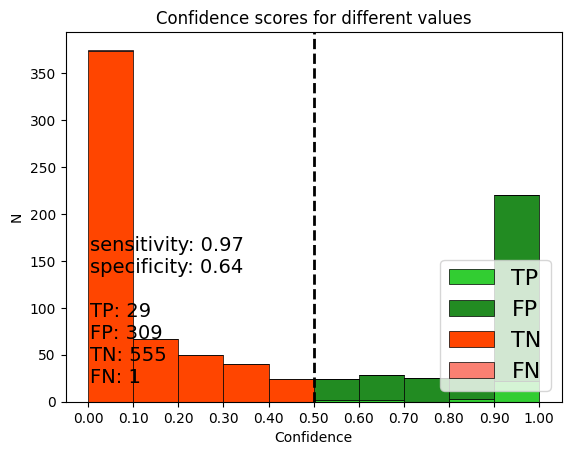

In [ ]:
def create_with_cutoff(cutoff):
  __, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
  TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]
  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
           edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
           stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
           label=['TP','FP','TN','FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="lower right", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff=0.5)